In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
print(os.listdir("../input/rsna-bone-age/"))


['boneage-training-dataset', 'boneage-test-dataset', 'boneage-test-dataset.csv', 'boneage-training-dataset.csv']


Separar datos

In [2]:
train_df = pd.read_csv("/kaggle/input/rsna-bone-age//boneage-training-dataset.csv")
print(train_df.shape)

(12611, 3)


Mostrar datos

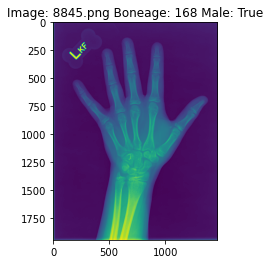

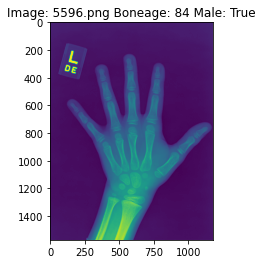

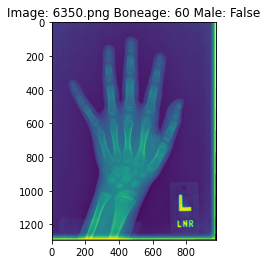

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

for img_id, boneage, male in train_df[['id','boneage','male']].sample(3).values:
    img_name = str(img_id) + '.png'
    img = mpimg.imread("../input/rsna-bone-age/boneage-training-dataset/boneage-training-dataset/"+img_name)
    plt.imshow(img)
    plt.title('Image: {} Boneage: {} Male: {}'.format(img_name, boneage, male))
    plt.show()

In [4]:
import numpy as np
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def read_and_prep_images(img_paths, img_height, img_width, color_mode="grayscale"):
    imgs = [load_img(img_path, target_size=(img_height, img_width), color_mode=color_mode) for img_path in img_paths]
    img_array = np.array([img_to_array(img) for img in imgs])
    #output = preprocess_input(img_array)
    return(img_array)

In [5]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D

# quadratic approach
quadratic = True
image_size = 128

# some kind of ratio if not quadratic approach
img_rows = image_size if quadratic else 144 
img_cols = image_size if quadratic else 114

initial_model = Sequential()

# Input Layer
initial_model.add(Conv2D(12, kernel_size=(4,4), activation='relu', input_shape=(img_rows, img_cols, 1)))


# Convulotional Layers
initial_model.add(Conv2D(20, kernel_size=(4,4), activation='relu'))
initial_model.add(Conv2D(20, kernel_size=(3,3), activation='relu'))

# Flattening
initial_model.add(Flatten())

# Dense Layer
initial_model.add(Dense(100))
initial_model.add(Dense(1))

initial_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [6]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout

bone_age_model = Sequential()

# Input Layer
bone_age_model.add(Conv2D(16, kernel_size=(7,7), strides=(2,2), activation='relu', input_shape=(img_rows, img_cols, 3)))
bone_age_model.add(Dropout(0.25))

# Convulotional Layers
bone_age_model.add(Conv2D(32, kernel_size=(5,5), strides=(2,2), activation='relu'))
bone_age_model.add(Dropout(0.25))
bone_age_model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
#bone_age_model.add(Dropout(0.25))
bone_age_model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
bone_age_model.add(Dropout(0.25))

# Flattening
bone_age_model.add(Flatten())

# Dense Layer
bone_age_model.add(Dense(256, activation='relu'))
#bone_age_model.add(Dropout(0.25))
bone_age_model.add(Dense(1))

bone_age_model.compile(loss='mean_squared_error', optimizer='adam', metrics='accuracy')

In [7]:
from keras.preprocessing.image import ImageDataGenerator


train_df['imagepath'] = [f'{pid}.png' for pid in train_df.id]
#Lazy way of creating training and test set.
train = train_df.head(10000)
test = train_df.tail(2600)


datagen=ImageDataGenerator(rescale=1./255, rotation_range=20, zoom_range=0.15,
                           width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
                           horizontal_flip=True, fill_mode="nearest")
train_generator=datagen.flow_from_dataframe(dataframe=train, 
                                            directory="../input/rsna-bone-age/boneage-training-dataset/boneage-training-dataset/", 
                                            x_col="imagepath", 
                                            y_col="boneage", 
                                            class_mode="raw", 
                                            target_size=(img_rows,img_cols), 
                                            batch_size=100)

valid_generator=datagen.flow_from_dataframe(dataframe=test, 
                                            directory="../input/rsna-bone-age/boneage-training-dataset/boneage-training-dataset/", 
                                            x_col="imagepath", 
                                            y_col="boneage", 
                                            class_mode="raw", 
                                            target_size=(img_rows,img_cols), 
                                            batch_size=100)

Found 10000 validated image filenames.
Found 2600 validated image filenames.


In [8]:


STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
history = bone_age_model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=50)

Epoch 1/50
  4/100 [>.............................] - ETA: 3:50 - loss: 11243.5273 - accuracy: 0.0000e+00

KeyboardInterrupt: 

In [ ]:
valid_generator=datagen.flow_from_dataframe(dataframe=test, 
                                            directory="../input/rsna-bone-age/boneage-training-dataset/boneage-training-dataset/", 
                                            x_col="imagepath", 
                                            y_col="boneage", 
                                            class_mode="raw", 
                                            target_size=(img_rows,img_cols), 
                                            batch_size=100)

Guardar el modelo

In [ ]:
bone_age_model.summary()

In [ ]:
bone_age_model.save('seqModelo.h5')

In [ ]:
import matplotlib.pyplot as plt
# Plot training & validation loss values
f, ax = plt.subplots(1,1, figsize=(15,10))
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
ax.grid(color='grey')
plt.show()

In [ ]:

bone_age_model.compile('adam','binary_crossentropy',  metrics='accuracy')

loss, accuracy = bone_age_model.evaluate_generator(next(valid_generator))
print('Restored model, accuracy: {:5.2f}%'.format(100*acc))

In [ ]:
testX, testY = next(validationDataGenerator.flow_from_dataframe(dataframe = df_val, directory = training, x_col = 'id', y_col = 'val_z', target_size = (imgSize, imgSize), batch_size = 2523, class_mode = 'raw'))

In [ ]:
next(valid_generator)[0]

In [ ]:
next(valid_generator)[1]

In [ ]:
prediccion =(bone_age_model.predict(next(valid_generator)[0], batch_size = 32, verbose = True))

In [ ]:
prediccion

In [ ]:
p = []
for i in prediccion:
    p.append(i[0])
p

In [ ]:
boneage_real = next(valid_generator)[1]
difer=[]
for i in range(len(p)):
    difer.append(boneage_real[i]-p[i])
difer

In [ ]:
count_correct=0
for i in dif:
    if (i<4.2 and i>-4.2):
        count_correct = count_correct + 1

acc = count_correct/2600

print("Accuracy: "+str(acc*100)+"%")

In [ ]:
for i in range(len(difer)):
    if (difer[i]<0):
        difer[i]=difer[i]*-1
average = sum(difer) / len(difer) 
print("Error absoluto promedio: "+str(average))
diferCuad=[]
for i in range(len(difer)):
    diferCuad.append(difer[i]*difer[i])
prom = sum(diferCuad) / len(diferCuad) 
print("Error cuadrado promedio: "+str(prom))

print(difer)
print("")
print(diferCuad)


In [ ]:
next(valid_generator)[0][0]

Vistas de accuracy

In [ ]:
for img_id, boneage, male in test[['id','boneage','male']].sample(3).values:
    tester=(np.array(test['id']))
    index = np.where(tester==(img_id))
    prediction = bone_age_model.predict(next(valid_generator)[0][index], verbose = True)
    img_name = str(img_id) + '.png'
    img = mpimg.imread("../input/rsna-bone-age/boneage-training-dataset/boneage-training-dataset/"+img_name)
    plt.imshow(img)
    dif = boneage-prediction[0][0]
    plt.title('Image: {} Boneage: {} Male: {} Predicted: {} Successful: {}'.format(img_name, boneage, male, prediction[0][0], (dif<4.2 and dif>-4.2)))
    plt.show()

In [ ]:
labels = 'Corrects', 'Incorrects'
sizes = [count_correct, 2600-count_correct]
fig1, ax1 = plt.subplots()
explode = (0, 0.1)
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [ ]:
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(boneage_real, p, color='r')
ax.set_xlabel('Real Boneage')
ax.set_ylabel('Predicted Boneage')
ax.set_title('Boneage')
limsx = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0, color="blue")
plt.show()